* zipcode, population density, college town
* birthday
* holiday,  summer/winter, seasonaltiy
* lunch/dinner
* promotion campaign

In [182]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
from operator import attrgetter
import matplotlib.colors as mcolors

In [6]:
# customer
"""
First time order characteristics
# number/%  of source
# number/% of State
# number/% shipping type
# number/% payment_method
# geography + postal code
# first order amount
# order hour and weekday and season and holiday
"""

"""
long term order characteristics
# number of orders
# average weekly orders
# Active period
# purchase frequency
# total spend
# average weekly spend
# order hour and weekday and season and holiday
"""

In [284]:
trans_data = pd.read_csv('churn_homework - churn_homework_orders.csv')
trans_data = trans_data.drop_duplicates()

trans_data['date_purchased'] = pd.to_datetime(trans_data['date_purchased'], errors='coerce')
trans_data['order_month'] = trans_data['date_purchased'].dt.to_period('M')
trans_data['order_weekday'] = trans_data['date_purchased'].dt.weekday
trans_data['order_hour'] = trans_data['date_purchased'].dt.hour
trans_data['cohort_start'] = trans_data.groupby('customer')['date_purchased'].transform('min').dt.to_period('M')

#print(trans_data.date_purchased.min(), trans_data.date_purchased.max())
trans_data.head(100)

,order_id,source,date_purchased,shipping_type,payment_method,promo_value,restaurant_total,customer,shops_id,State,postal_code,order_month,order_weekday,order_hour,cohort_start
0,70134510,iosapp,2019-12-13 15:04:35,Pickup,cash,0,16.07,2013210176,3660,NJ,8872,2019-12,4,15,2019-03
1,75620262,iosapp,2020-02-09 14:33:59,Pickup,cash,0,20.84,2013210176,3660,NJ,8872,2020-02,6,14,2019-03
2,54598197,iosapp,2019-06-14 15:43:37,Pickup,credit,0,23.73,2013210176,3660,NJ,8872,2019-06,4,15,2019-03
3,62754102,partner_website,2019-09-23 14:19:48,Pickup,credit,0,18.23,7327251578,3660,NJ,8872,2019-09,0,14,2019-03
4,48221004,slicelife,2019-03-23 10:26:41,Delivery,credit,0,36.44,7327251578,3660,NJ,8872,2019-03,5,10,2019-03
5,76427382,iosapp,2020-02-17 14:20:46,Pickup,cash,0,21.86,2013210176,3660,NJ,8872,2020-02,0,14,2019-03
6,57265335,iosapp,2019-07-18 15:56:59,Delivery,cash,0,26.19,7188203445,3660,NJ,8872,2019-07,3,15,2019-04
7,71010144,iosapp,2019-12-22 12:15:14,Pickup,cash,0,46.56,2013210176,3660,NJ,8872,2019-12,6,12,2019-03
8,52950228,iosapp,2019-05-24 15:05:59,Pickup,credit,0,22.10,2013210176,3660,NJ,8872,2019-05,4,15,2019-03
9,72823518,iosapp,2020-01-11 15:15:20,Pickup,credit,0,10.54,2013210176,3660,NJ,8872,2020-01,5,15,2019-03


In [350]:
#first_time_data = trans_data[trans_data['date_purchased'].isin(trans_data.groupby('customer').min()['date_purchased'].values)]
first_time_purch = pd.DataFrame(trans_data.groupby(['customer']) \
                                          .agg({'date_purchased': 'min'}) \
                                          .reset_index(drop=False))

customer_data = pd.merge(trans_data, first_time_purch, on=['date_purchased','customer'], how='inner')

customer_data['date_purchased'] = pd.to_datetime(customer_data['date_purchased'], errors='coerce')
customer_data['first_order_month'] = customer_data['date_purchased'].dt.to_period('M')
customer_data['first_order_weekday'] = customer_data['date_purchased'].dt.weekday
customer_data['first_order_hour'] = customer_data['date_purchased'].dt.hour
customer_data['cohort_start'] = customer_data.groupby('customer')['date_purchased'].transform('min').dt.to_period('M')


customer_data.rename(columns = {'date_purchased': 'first_date_purchased', \
                                'source':'first_source', \
                                'shipping_type':'first_shipping_type', \
                                'payment_method':'first_payment_method', \
                                'promo_value': 'first_promo_value', \
                                'restaurant_total': 'first_restaurant_total', \
                                'shop_id': 'first_shop_id', \
                                'State': 'first_State', \
                                'postal_code': 'fist_postal_code'
                                }, inplace = True)

31.815812000000033 26.825000000000003


In [354]:
customer_data_complete = pd.merge(trans_data, customer_data, on='customer', how='left')

'   \nwith sns.axes_style("darkgrid"):\n    ax = f.add_subplot(gs[0, 1])\n    sns.countplot(x="order_month",                   #order=[\'2019-03\',\'2019-04\',\'2019-05\',\'2019-06\',\'2019-07\',\'2019-08\',                  #       \'2019-09\',\'2019-10\',\'2019-11\',\'2019-12\',\'2020-01\',\'2020-02\',\'2020-03\'],                   data=trans_data, palette="Set2")\n    ax.set(xlabel=\'Order Month\', ylabel=\'Number of Orders\')\n    \nwith sns.axes_style("darkgrid"):\n    ax = f.add_subplot(gs[1, 0])\n    sns.countplot(x="shipping_type", data=trans_data, palette="Set2")\n    ax.set(xlabel=\'Shipping Type\', ylabel=\'Number of Orders\')\n    \nwith sns.axes_style("darkgrid"):\n    ax = f.add_subplot(gs[1, 1])\n    sns.countplot(x="source", data=trans_data, palette="Set2")\n    ax.set(xlabel=\'Source\', ylabel=\'Number of Orders\')\n'

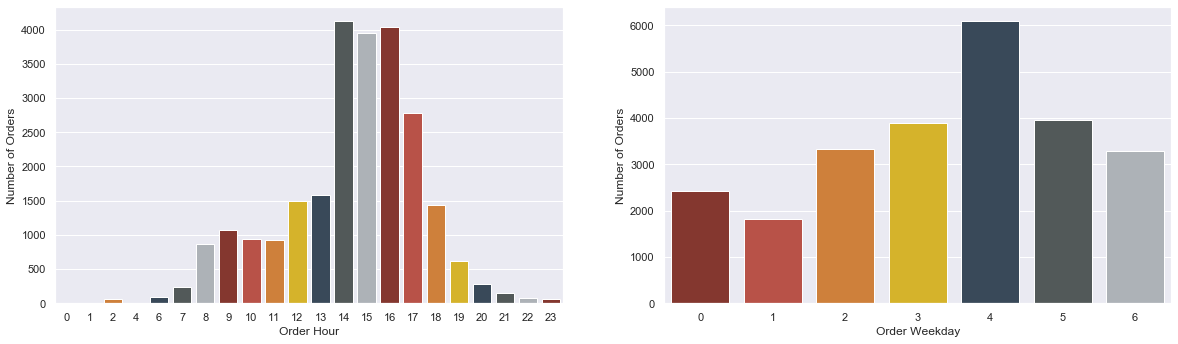

In [391]:
flatui = ["#922B21",'#CB4335',"#E67E22","#F1C40F","#34495e","#515A5A", "#ABB2B9"]
#sns.palplot(sns.color_palette(flatui))

f = plt.figure(figsize=(20, 12))
gs = f.add_gridspec(2, 2)

with sns.axes_style("darkgrid"):
    ax = f.add_subplot(gs[0, 0])
    sns.countplot(x="first_order_hour", data=customer_data_complete, palette=flatui)
    ax.set(xlabel='Order Hour', ylabel='Number of Orders')

with sns.axes_style("darkgrid"):
    ax = f.add_subplot(gs[0, 1])
    sns.countplot(x="first_order_weekday", \
                  data=customer_data_complete, palette=flatui)
    ax.set(xlabel='Order Weekday', ylabel='Number of Orders')    
"""   
with sns.axes_style("darkgrid"):
    ax = f.add_subplot(gs[0, 1])
    sns.countplot(x="order_month", \
                  #order=['2019-03','2019-04','2019-05','2019-06','2019-07','2019-08',\
                  #       '2019-09','2019-10','2019-11','2019-12','2020-01','2020-02','2020-03'], \
                  data=trans_data, palette="Set2")
    ax.set(xlabel='Order Month', ylabel='Number of Orders')
    
with sns.axes_style("darkgrid"):
    ax = f.add_subplot(gs[1, 0])
    sns.countplot(x="shipping_type", data=trans_data, palette="Set2")
    ax.set(xlabel='Shipping Type', ylabel='Number of Orders')
    
with sns.axes_style("darkgrid"):
    ax = f.add_subplot(gs[1, 1])
    sns.countplot(x="source", data=trans_data, palette="Set2")
    ax.set(xlabel='Source', ylabel='Number of Orders')
"""

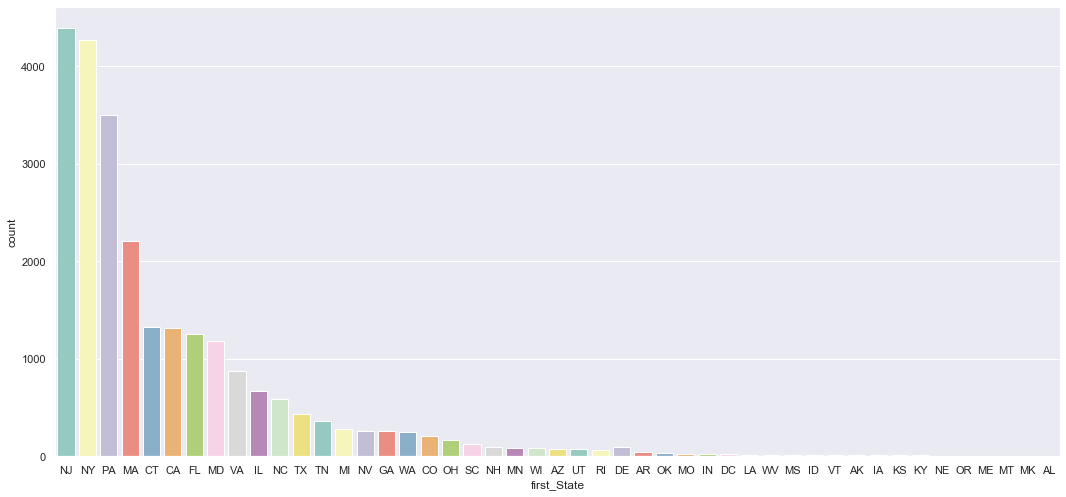

In [388]:
sns.set(rc={'figure.figsize':(18,8.27)})
ax = sns.countplot(x="first_State", data=customer_data_complete, \
                   order = customer_data_complete.State.value_counts().index, \
                   palette="Set3") 

In [277]:
trans_data.order_month.value_counts()

2019-12    2212
2020-01    2195
2019-11    2188
2019-10    2180
2019-09    2152
2019-08    2150
2020-02    2048
2019-05    2027
2019-07    1989
2019-06    1931
2019-04    1784
2019-03    1210
2020-03     750
Freq: M, Name: order_month, dtype: int64

In [244]:
trans_data.postal_code.value_counts()

10305    178
32822    176
6770     166
8016     146
21040    136
7856     132
8865     129
21075    123
21222    123
7456     123
19053    122
10019    121
6790     121
10314    119
8638     118
10025    118
2379     116
6010     114
7882     112
7065     111
2346     109
8054     104
11204    103
11209     96
19067     96
29407     93
10309     92
19422     91
10128     91
19136     87
        ... 
30344      1
18030      1
91722      1
30168      1
60827      1
75042      1
19711      1
48353      1
79072      1
8755       1
19022      1
90731      1
11362      1
22205      1
7860       1
30313      1
77346      1
46545      1
32136      1
7508       1
89148      1
19102      1
48176      1
7204       1
48128      1
29609      1
7012       1
2838       1
33511      1
92139      1
Name: postal_code, Length: 1791, dtype: int64

In [242]:
trans_data.shops_id.value_counts()

37074     147
15069     137
61743     129
10932     122
7152      118
17919     116
26076     115
44538     110
14973     106
321        99
360        99
31548      93
47700      88
33126      83
17442      83
41010      78
45108      74
83490      71
46833      71
5073       71
16134      71
27405      70
55398      68
28647      67
61704      67
10977      62
561        61
25998      61
25344      61
26670      61
         ... 
49725       1
23118       1
35412       1
11016       1
141792      1
140025      1
12915       1
17085       1
49869       1
76512       1
33531       1
14850       1
45951       1
47250       1
53439       1
2196        1
65685       1
6294        1
59544       1
64422       1
10416       1
18636       1
56118       1
45267       1
12531       1
33045       1
11064       1
41679       1
16749       1
142512      1
Name: shops_id, Length: 2907, dtype: int64

In [240]:
trans_cust_cohort = pd.DataFrame(trans_data.groupby(['postal_code']) \
                                   .agg({'shops_id': 'nunique'}) \
                                   .reset_index(drop=False) \
                                   .rename(columns={'shops_id':'n_shops_id'}))
trans_cust_cohort.sort_values(['n_shops_id'],ascending=False)

,postal_code,n_shops_id
84,2148,11
486,10309,11
947,21222,10
140,6010,10
460,10025,9
553,11209,9
88,2155,9
482,10305,8
334,8016,8
28,1760,8


In [169]:
print(trans_data.date_purchased.min(),trans_data.date_purchased.max())
print(trans_data.customer.nunique())
print(trans_data.source.unique(), trans_data.shipping_type.unique(), trans_data.payment_method.unique())
print(trans_data.State.unique())
print(trans_data.promo_value.unique())
print(trans_data.postal_code.unique())

2019-03-13T06:36:53.000Z 2020-03-12T21:04:44.000Z
2500
['iosapp' 'partner_website' 'slicelife' 'web' 'androidapp' 'partner_button'
 'call-center'] ['Pickup' 'Delivery'] ['cash' 'credit']
['NJ' 'CT' 'MD' 'NC' 'AZ' 'CA' 'VA' 'PA' 'MA' 'NY' 'RI' 'WA' 'TN' 'TX' 'NV'
 'GA' 'FL' 'SC' 'IL' 'CO' 'MI' 'OH' 'DC' 'WI' 'DE' 'MN' 'NH' 'AR' 'UT' 'IN'
 'VT' 'MS' nan 'MO' 'NE' 'IA' 'KY' 'LA' 'AL' 'ID' 'KS' 'AK' 'MT' 'OK' 'OR'
 'WV' 'ME' 'MK']
[0 1 3 5 4 2]
[ 8872  6770 21075 ..., 10528 21702  8852]


In [201]:
"""
trans_cust_cohort = pd.DataFrame(trans_cust_data.groupby(['customer']) \
                                   .agg({'State': 'nunique'}) \
                                   .reset_index(drop=False) \
                                   .rename(columns={'State':'n_state'}))

trans_cust_cohort.n_state.value_counts()
"""
# Assume first order state is user's main state
# Can do calculation and assign the most appeared states is user's main state

1    2418
2      71
3       6
0       3
4       2
Name: n_state, dtype: int64

In [173]:
trans_data.promo_value.unique()

array([0, 1, 3, 5, 4, 2])

In [174]:
def var_check(var_str):
    trans_state = trans_data[['order_id',var_str,'order_month']]

    trans_state_pivot = trans_state.pivot_table(index = var_str, \
                                                columns ='order_month', \
                                                values ='order_id', \
                                                aggfunc='count',\
                                                fill_value=0)
    cust_month = trans_data.groupby([var_str,'customer']) \
                           .agg({'order_month':'min'}) \
                           .reset_index() \
                           .rename(columns={'order_month':'first_month'})

    cust_month_pivot = cust_month.pivot_table(index = var_str, \
                                                columns ='first_month', \
                                                values ='customer', \
                                                aggfunc='count',\
                                                fill_value=0) 
    return cust_month_pivot

In [179]:
cust_month_pivot = var_check('promo_value')
cust_month_pivot

first_month,2019-03,2019-04,2019-05,2019-06,2019-07,2019-08,2019-09,2019-10,2019-11,2019-12,2020-01,2020-02,2020-03
promo_value,,,,,,,,,,,,,
0,624,376,240,167,166,164,146,125,135,99,92,75,30
1,15,21,15,26,14,6,14,15,13,9,4,3,0
2,12,11,12,22,20,11,12,13,9,6,3,2,0
3,7,15,18,29,8,11,13,14,8,12,1,3,0
4,13,9,8,21,7,10,7,15,8,12,3,1,1
5,6,4,6,9,12,4,11,6,2,3,2,1,0


In [147]:
trans_state_pivot

order_month,2019-03,2019-04,2019-05,2019-06,2019-07,2019-08,2019-09,2019-10,2019-11,2019-12,2020-01,2020-02,2020-03
State,,,,,,,,,,,,,
AK,0,0,0,1,1,1,2,1,0,2,1,1,0
AL,0,0,0,0,0,0,0,0,1,0,0,1,0
AR,1,1,3,1,1,1,3,2,2,2,1,2,0
AZ,1,3,2,7,5,3,8,7,5,7,5,3,2
CA,31,50,60,59,64,62,58,69,63,63,63,61,27
CO,9,15,12,10,13,9,10,7,10,8,6,8,3
CT,37,44,44,43,55,55,55,59,53,60,52,61,31
DC,0,3,2,1,0,3,0,1,2,2,1,2,0
DE,1,3,4,3,2,5,3,1,2,2,3,5,2


In [148]:
#Lastly, we plot the retention matrix as a heatmap
def heat_matrix_func(retention_matrix, title_string):
    with sns.axes_style("white"):
        fig, ax = plt.subplots(1, 2, figsize=(18, 15), sharey=True, gridspec_kw={'width_ratios': [1, 11]})

        # retention matrix
        sns.heatmap(retention_matrix, 
                    mask=retention_matrix.isnull(), 
                    annot=True, 
                    fmt="d",
                    #fmt='.0%', 
                    cmap='RdYlGn', 
                    ax=ax[1])
        ax[1].set_title(title_string, fontsize=16)
        ax[1].set(xlabel='# of periods', ylabel='')
        """
        # cohort size
        cohort_size_df = pd.DataFrame(cohort_size).rename(columns={0: 'cohort_size'})
        white_cmap = mcolors.ListedColormap(['white'])
        sns.heatmap(cohort_size_df, 
                    annot=True, 
                    cbar=False, 
                    fmt='g', 
                    cmap=white_cmap, 
                    ax=ax[0])
        """
        fig.tight_layout()

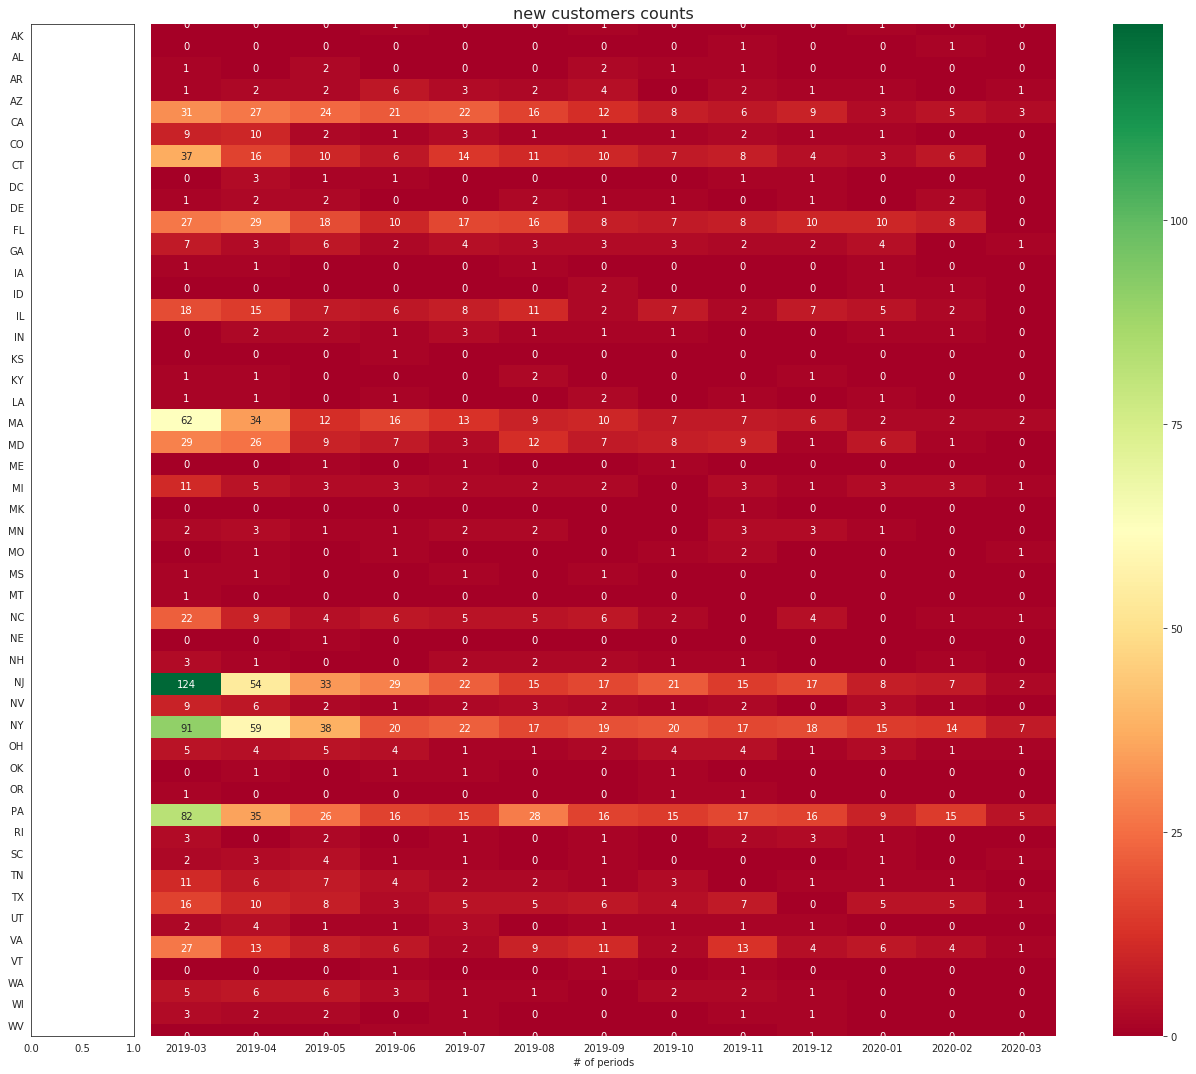

In [166]:
heat_matrix_func(cust_month_pivot, 'new customers counts')

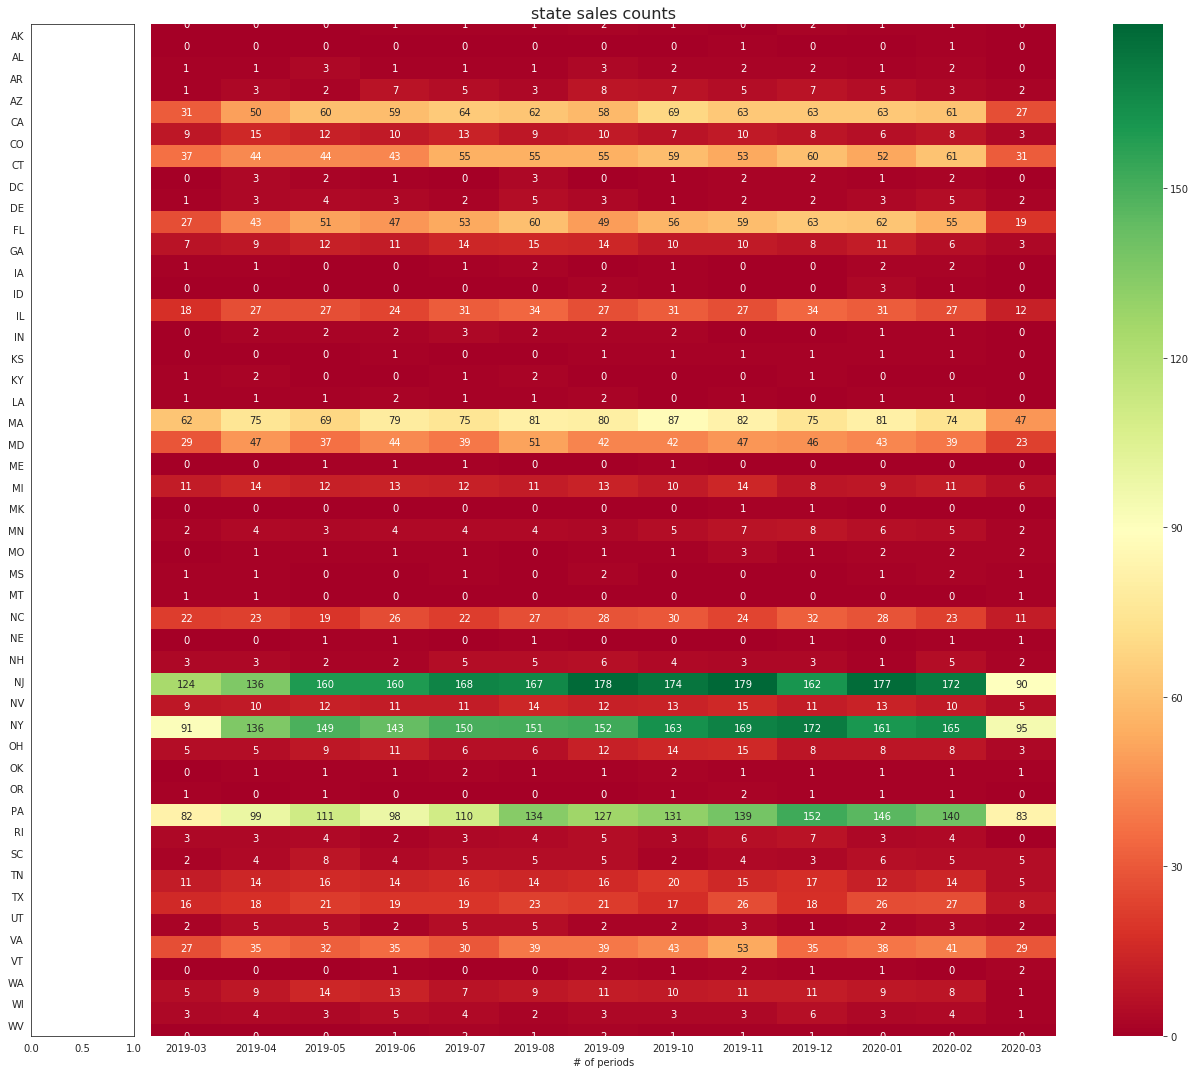

In [149]:
heat_matrix_func(trans_state_pivot, 'state sales counts')

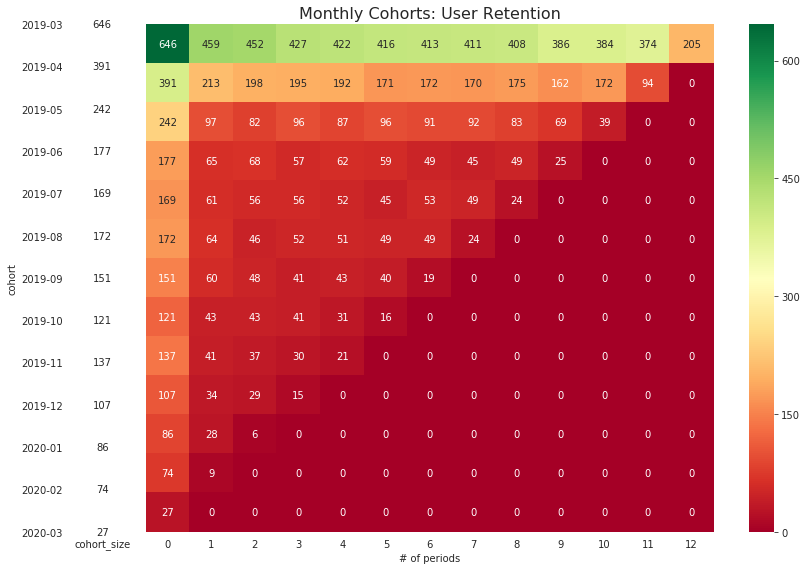

In [157]:
with sns.axes_style("white"):
    fig, ax = plt.subplots(1, 2, figsize=(12, 8), sharey=True, gridspec_kw={'width_ratios': [1, 11]})
    
    # retention matrix
    sns.heatmap(cohort_pivot, 
                mask=cohort_pivot.isnull(), 
                annot=True, 
                fmt='d', 
                cmap='RdYlGn', 
                ax=ax[1])
    ax[1].set(xlabel='# of periods',
              ylabel='')

    # cohort size
    cohort_size_df = pd.DataFrame(cohort_size).rename(columns={0: 'cohort_size'})
    white_cmap = mcolors.ListedColormap(['white'])
    sns.heatmap(cohort_size_df, 
                annot=True, 
                cbar=False, 
                fmt='g', 
                cmap=white_cmap, 
                ax=ax[0])

    fig.tight_layout()

In [21]:
trans_data.groupby(['customer']).agg({'order_id':'count', 'restaurant_total': 'sum', 'date_purchased':'min'}).reset_index().rename(columns={'date_purchased':'first_date'})

,customer,order_id,restaurant_total,first_date
0,2012144625,4,148.52,2019-03-15T17:07:00.000Z
1,2012383018,6,192.54,2019-03-23T16:11:10.000Z
2,2012416238,36,470.84,2019-03-16T10:05:01.000Z
3,2012596116,1,29.82,2019-07-18T15:19:08.000Z
4,2012904791,38,968.52,2019-03-15T10:23:41.000Z
5,2012944224,13,569.09,2019-08-26T16:28:49.000Z
6,2013140016,24,671.47,2019-03-17T13:22:10.000Z
7,2013143616,44,1901.50,2019-03-15T09:48:38.000Z
8,2013210176,23,546.82,2019-03-27T14:15:46.000Z
9,2013211560,10,335.84,2019-05-03T15:00:14.000Z


In [156]:
cohort_pivot

period_number,0,1,2,3,4,5,6,7,8,9,10,11,12
cohort,,,,,,,,,,,,,
2019-03,646,459,452,427,422,416,413,411,408,386,384,374,205
2019-04,391,213,198,195,192,171,172,170,175,162,172,94,0
2019-05,242,97,82,96,87,96,91,92,83,69,39,0,0
2019-06,177,65,68,57,62,59,49,45,49,25,0,0,0
2019-07,169,61,56,56,52,45,53,49,24,0,0,0,0
2019-08,172,64,46,52,51,49,49,24,0,0,0,0,0
2019-09,151,60,48,41,43,40,19,0,0,0,0,0,0
2019-10,121,43,43,41,31,16,0,0,0,0,0,0,0
2019-11,137,41,37,30,21,0,0,0,0,0,0,0,0


In [365]:
def var_check_ret(trans_data):
    trans_cust_data = trans_data[['customer','order_id_x','date_purchased']].drop_duplicates()
    
    trans_cust_data['date_purchased'] = pd.to_datetime(trans_cust_data['date_purchased'], errors='coerce')
    trans_cust_data['order_month'] = trans_cust_data['date_purchased'].dt.to_period('M')
    trans_cust_data['cohort'] = trans_cust_data.groupby('customer')['date_purchased'].transform('min').dt.to_period('M')


    trans_cust_cohort = trans_cust_data.groupby(['cohort', 'order_month']) \
                                       .agg({'customer': 'nunique'}) \
                                       .reset_index(drop=False) \
                                       .rename(columns={'customer':'n_customers'})
    trans_cust_cohort['period_number'] = trans_cust_cohort.order_month - trans_cust_cohort.cohort

    cohort_pivot = trans_cust_cohort.pivot_table(index = 'cohort',columns = 'period_number',values = 'n_customers', fill_value=0)
    cohort_size = cohort_pivot.iloc[:,0]
    retention_matrix = cohort_pivot.divide(cohort_size, axis = 0)

    #Lastly, we plot the retention matrix as a heatmap
    with sns.axes_style("white"):
        fig, ax = plt.subplots(1, 2, figsize=(10, 8), sharey=True, gridspec_kw={'width_ratios': [1, 11]})

        # retention matrix
        sns.heatmap(retention_matrix, 
                    mask=retention_matrix.isnull(), 
                    annot=True, 
                    fmt='.0%', 
                    cmap='RdYlGn', 
                    ax=ax[1])
        ax[1].set_title('Monthly Cohorts: User Retention', fontsize=16)
        ax[1].set(xlabel='# of periods',
                  ylabel='')

        # cohort size
        cohort_size_df = pd.DataFrame(cohort_size).rename(columns={0: 'cohort_size'})
        white_cmap = mcolors.ListedColormap(['white'])
        sns.heatmap(cohort_size_df, 
                    annot=True, 
                    cbar=False, 
                    fmt='g', 
                    cmap=white_cmap, 
                    ax=ax[0])

        fig.tight_layout()

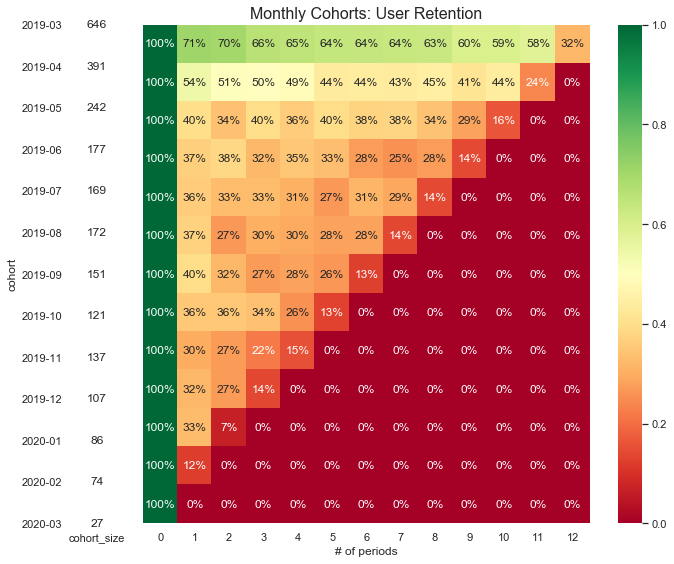

In [366]:
var_check_ret(customer_data_complete)

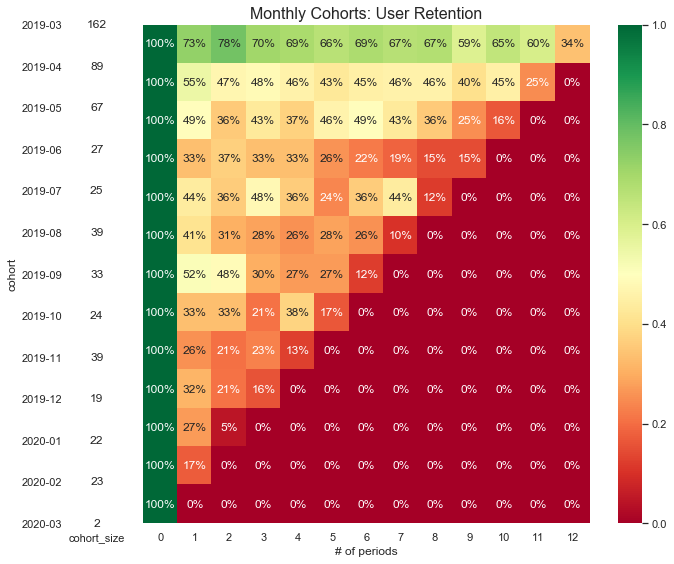

In [387]:
var_check_ret(customer_data_complete[customer_data_complete.first_order_weekday==4])

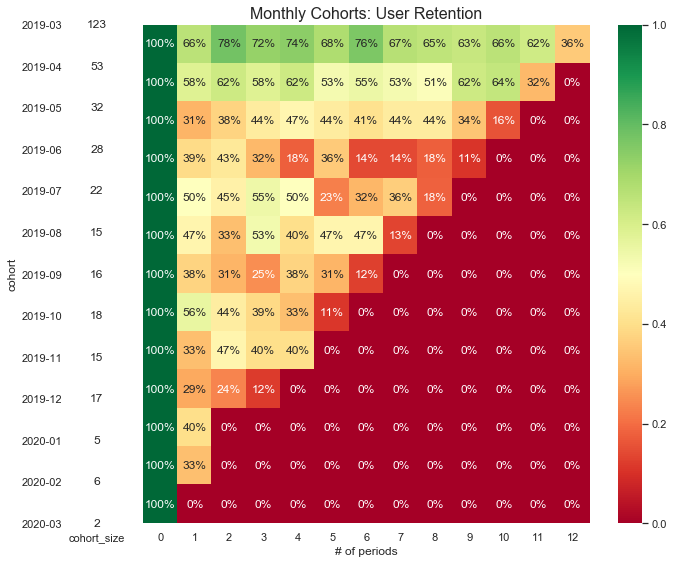

In [392]:
var_check_ret(customer_data_complete[customer_data_complete.first_State=='NJ'])

In [386]:
customer_data_complete.head(4)

,order_id_x,source,date_purchased,shipping_type,payment_method,promo_value,restaurant_total,customer,shops_id_x,State,...,first_payment_method,first_promo_value,first_restaurant_total,shops_id_y,first_State,fist_postal_code,first_order_month,first_order_weekday,first_order_hour,cohort_start
0,70134510,iosapp,2019-12-13T15:04:35.000Z,Pickup,cash,0,16.07,2013210176,3660,NJ,...,credit,0,35.04,3660,NJ,8872,2019-03,2,14,2019-03
1,75620262,iosapp,2020-02-09T14:33:59.000Z,Pickup,cash,0,20.84,2013210176,3660,NJ,...,credit,0,35.04,3660,NJ,8872,2019-03,2,14,2019-03
2,54598197,iosapp,2019-06-14T15:43:37.000Z,Pickup,credit,0,23.73,2013210176,3660,NJ,...,credit,0,35.04,3660,NJ,8872,2019-03,2,14,2019-03
3,62754102,partner_website,2019-09-23T14:19:48.000Z,Pickup,credit,0,18.23,7327251578,3660,NJ,...,credit,0,36.44,3660,NJ,8872,2019-03,5,10,2019-03
